### NNS - Cosine similarity and weighted cosine similarity

Let's take a simple dataset with gaussian clusters. The idea is to define a method to find similar points. 
We can use a direct distance measurement method calculating $\lVert \textbf{x}_{i} - \textbf{x}_{j} \lVert$ and selecting the neighbor points as being within a circle of radius $\epsilon$. Which consists of placing the frame of reference at the point $\textbf{x}_{i}$. <br>
Or we can keep the frame of reference at (0,0) and use a similar approach in polar coordinates $\left[x_{i}^{0}, x_{i}^{1}\right] = \left[r\cos{\theta}, r\sin{\theta}\right]$. In this frame, we can leverage the vectorial implementation of the dot product by regarding each point as a vector from the origin and compare them through their angle and norms. 

#### Build the data

In [1]:
import torch
from torch import tensor
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [4]:
torch.manual_seed(11)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [5]:
from torch.distributions import MultivariateNormal

In [6]:
n_centers = 5
n_pts = 500
centers = torch.rand(n_centers, 2)*60-30
centers.shape, centers

(torch.Size([5, 2]),
 tensor([[-21.057,  -0.807],
         [ 29.140, -19.896],
         [  5.037,  11.616],
         [  4.985, -22.294],
         [  4.327,  25.490]]))

In [7]:
def generate_points(c, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [8]:
dat_l = [generate_points(c,5.) for c in centers]
dat = torch.cat(dat_l)

In [9]:
def plot_data(centers, data_l):
    for c, dat in zip(centers, data_l):
        plt.scatter(dat[:,0], dat[:,1], s=1, alpha=0.5)
        plt.plot(*c, marker='x', markersize=7, color='k', mew=5)
        plt.plot(*c, marker='x', markersize=3, color='orange', mew=1)

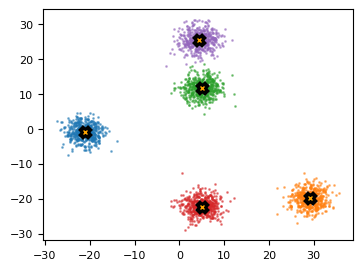

In [10]:
plot_data(centers,dat_l)

In [12]:
X = dat.clone()
X = X[torch.randperm(X.shape[0])]

#### simple cosine projection $\rightarrow$ $\cdot$  product

Should have a bias perpendicular to the reference vector (the projection of any point along the perpendicular of a vector is constant). <br>
For each point(vector) we calculate the dot product with every other point(vector). The diagonal is the norm squared of each vector $(0,0)\rightarrow(x_{i}^{0},x_{i}^{1})$.

In [13]:
dot_mat = X @ X.transpose(0,1)
dot_mat.shape, dot_mat

(torch.Size([2500, 2500]),
 tensor([[1382.993,  633.754, -128.240,  ..., -189.815, -210.235,  -72.961],
         [ 633.754,  576.511, -348.200,  ..., -270.009, -572.620, -306.768],
         [-128.240, -348.200,  304.705,  ...,  202.765,  501.335,  283.290],
         ...,
         [-189.816, -270.009,  202.765,  ...,  143.142,  333.552,  184.877],
         [-210.235, -572.620,  501.335,  ...,  333.552,  824.855,  466.128],
         [ -72.961, -306.768,  283.290,  ...,  184.877,  466.128,  264.991]]))

With einsum as well:

In [16]:
dot_mat = torch.einsum('ij,kj->ik',X,X)
dot_mat.shape, dot_mat

(torch.Size([2500, 2500]),
 tensor([[1382.993,  633.754, -128.240,  ..., -189.815, -210.235,  -72.961],
         [ 633.754,  576.511, -348.200,  ..., -270.009, -572.620, -306.768],
         [-128.240, -348.200,  304.705,  ...,  202.765,  501.335,  283.290],
         ...,
         [-189.816, -270.009,  202.765,  ...,  143.142,  333.552,  184.877],
         [-210.235, -572.620,  501.335,  ...,  333.552,  824.855,  466.128],
         [ -72.961, -306.768,  283.290,  ...,  184.877,  466.128,  264.991]]))

From the dot product matrix, we want to build a score, the closer points should be the points that have a similar dot product value to the reference point with itself.<br>
To achieve this, we can divide each row by the diagonal, that is, each vector projection by the reference vector on itself. We can tell right away that it won't work because it will select the points along the perpendicular line to the reference vector.

In [13]:
dot_diag = dot_mat.diagonal(0)[:,None]
dot_diag

tensor([[1382.993],
        [ 576.511],
        [ 304.705],
        ...,
        [ 143.142],
        [ 824.855],
        [ 264.991]])

In [14]:
dot_mat/dot_diag

tensor([[ 1.000,  0.458, -0.093,  ..., -0.137, -0.152, -0.053],
        [ 1.099,  1.000, -0.604,  ..., -0.468, -0.993, -0.532],
        [-0.421, -1.143,  1.000,  ...,  0.665,  1.645,  0.930],
        ...,
        [-1.326, -1.886,  1.417,  ...,  1.000,  2.330,  1.292],
        [-0.255, -0.694,  0.608,  ...,  0.404,  1.000,  0.565],
        [-0.275, -1.158,  1.069,  ...,  0.698,  1.759,  1.000]])

We can project the result on $\left]0,1\right]$ with $\exp\left(-\big\lvert1-\frac{(\textbf{XX}^{T})}{diag(\textbf{XX}^{T})}\big\lvert\right)$ for ease to select the points closer to 1 as being the most similar to the reference vector:

In [15]:
sim_mat = torch.exp(-abs(1- dot_mat/dot_mat.diag(0)[:,None]))
sim_mat

tensor([[1.000, 0.582, 0.335,  ..., 0.321, 0.316, 0.349],
        [0.905, 1.000, 0.201,  ..., 0.230, 0.136, 0.216],
        [0.242, 0.117, 1.000,  ..., 0.716, 0.524, 0.932],
        ...,
        [0.098, 0.056, 0.659,  ..., 1.000, 0.264, 0.747],
        [0.285, 0.184, 0.676,  ..., 0.551, 1.000, 0.647],
        [0.279, 0.116, 0.933,  ..., 0.739, 0.468, 1.000]])

In [16]:
dissim_bool = sim_mat<0.5
sim_bool = sim_mat>0.95

In [27]:
def plot_nns(pt, nns, X, plot_angle=False, cos=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,8))
    for k in X[nns]:
        ax.plot(*torch.stack([pt, k]).transpose(0,1), alpha=0.2, color="C0")
    ax.scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
    ax.scatter(*pt.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)
    ax.scatter(0,0, marker='+', c='black', alpha=0.5)
    if plot_angle:
        theta = torch.acos(tensor(cos))
        xs = torch.linspace(-30,30,10)
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0]))*xs, linewidth=1, alpha=0.5, color='C3')
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0])+theta)*xs, linewidth=1, alpha=0.5, color='C4')
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0])-theta)*xs, linewidth=1, alpha=0.5, color='C4')
    ax.set_xlim(-30, 38)
    ax.set_ylim(-32, 35);

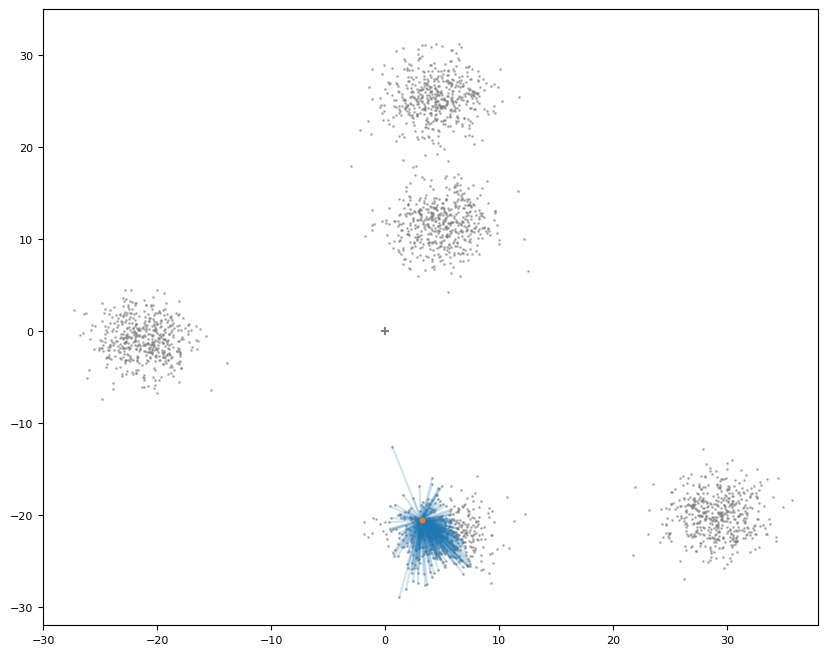

In [28]:
plot_nns(X[390], sim_bool[390].nonzero().squeeze(), X)

We can try to normalize the result to extract only the angular information with the cosine similarity and then proceed to adjust the criterion to account for the distance from the origin.

#### cosine similarity
The cosine similarity is defined as: $$\frac{A\cdot B}{\lVert A\rVert \times \lVert B\rVert} = \frac{\sum_{i=1}^{n}A_{i}B_{i}}{\sqrt{\sum_{i=1}^{n}A_{i}^{2}}\sqrt{\sum_{i=1}^{n}B_{i}^{2}}}$$ 

Here the normalizing factor $\lVert A\rVert \times \lVert B\rVert$ is the diagonal of the matrix of $\textbf{X}\textbf{X}^{T}$ product. <br>

One should note that this measurement is useful if we only care about the radial separation of the data, ie the angle between the vectors. <br>
Let's see how it affects the nearest neighbors search:

In [23]:
dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]
norm_mat = dot_diag@dot_diag.transpose(0,1)
norm_mat[:3]

tensor([[1382.993,  892.922,  649.157,  ...,  444.932, 1068.068,  605.376],
        [ 892.922,  576.511,  419.125,  ...,  287.268,  689.592,  390.858],
        [ 649.157,  419.125,  304.705,  ...,  208.845,  501.335,  284.155]])

In [22]:
# Same with einsum, but there is no performance gain
norm_mat = torch.einsum('ij,kj->ik', dot_diag,dot_diag)
norm_mat[:3]

tensor([[1382.993,  892.922,  649.157,  ...,  444.932, 1068.068,  605.376],
        [ 892.922,  576.511,  419.125,  ...,  287.268,  689.592,  390.858],
        [ 649.157,  419.125,  304.705,  ...,  208.845,  501.335,  284.155]])

In [29]:
%%timeit -n 5
dot_mat = X @ X.transpose(0,1)
dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]
norm_mat = dot_diag@dot_diag.transpose(0,1)
sim_mat = dot_mat/norm_mat
sim_mat

9.87 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [30]:
%%timeit -n 5
d_m = torch.einsum('ij,kj->ik',X,X)
d_diag = torch.sqrt(d_m.diagonal(0))[:,None]
n_mat = torch.einsum('ij,kj->ik', d_diag,d_diag)
s_mat = dot_mat/n_mat
s_mat

10.5 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [30]:
def cossim(X):
    dot_mat = X @ X.transpose(0,1)
    dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]
    norm_mat = dot_diag@dot_diag.transpose(0,1)
    sim_mat = dot_mat/norm_mat
    return sim_mat

In [31]:
sim_mat = cossim(X)
sim_mat.min(), sim_mat.max()

(tensor(-1.000), tensor(1.000))

The cos similarity is within $[-1,1]$. A value of 1 means exactly the reference angle, a value of 0.99 means: $$\frac{\arccos(0.99)}{\pi}\times360^{\circ}$$

In [32]:
dissim_bool = sim_mat<-0.5
sim_bool = sim_mat>0.99

In [33]:
torch.acos(tensor(0.99))/torch.pi*360

tensor(16.219)

If we take a cutoff value of 0.99, we select an angle $\theta$ that represents $\arccos(0.99) = \pm16.216^{\circ} $ 

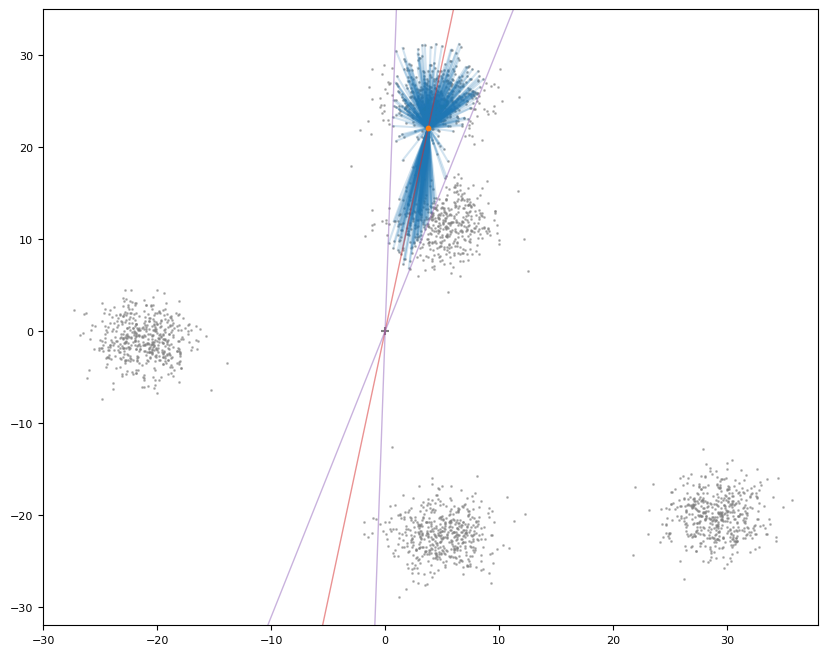

In [34]:
plot_nns(X[330], sim_bool[330].nonzero().squeeze(), X, plot_angle=True, cos=0.99)

The problem here is that the similarity only depens on the angle of the vectors, whereas we want the magnitude to mean something. 
We can normalize the coordinates in $\left[-1,1\right]$ to homogenize the vectors magnitude and use the dot product multiplied by a factor that accounts for the magnitude of the dot product simetrically around the reference point's norm.

In [34]:
def normalize(X):
    Xmin, Xmax = X.min(), X.max()
    return 2*(X-Xmin)/(Xmax-Xmin) - 1

In [35]:
X_norm = normalize(X)

The idea is to have both information on the angular similarity and the magnitude similarity. The angular similarity is given by the dot product, the magnitude comparison can be obtained by the difference of the norms $\lVert \textbf{u} \lVert - \lVert \textbf{v} \lVert$ this calculation is fast but the difference has a spherical symmetry and will tend to select nns along the arc of a circle of radius $\lVert \textbf{u} \lVert-\delta < r < \lVert \textbf{u} \lVert+\delta$. The best choice would be to use the norm of the difference $\lVert \textbf{u} - \textbf{v} \lVert$ to account for the real distance between the points and not the distance from the origin, but it is slower to calculate.<br>  
We can then take the exponential of $\exp(-\text{abs}(\text{res}))$ to cast the result in $\left]0,1\right]$:

In [36]:
abs(dot_diag-dot_diag.transpose(0,1))

tensor([[ 0.000, 13.178, 19.733,  ..., 25.224,  8.468, 20.910],
        [13.178,  0.000,  6.555,  ..., 12.046,  4.710,  7.732],
        [19.733,  6.555,  0.000,  ...,  5.492, 11.264,  1.177],
        ...,
        [25.224, 12.046,  5.492,  ...,  0.000, 16.756,  4.314],
        [ 8.468,  4.710, 11.264,  ..., 16.756,  0.000, 12.442],
        [20.910,  7.732,  1.177,  ...,  4.314, 12.442,  0.000]])

In [37]:
X_norm = normalize(X)
# X_norm = X
dot_mat = X_norm @ X_norm.transpose(0,1)
dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]
norm_mat = dot_diag@dot_diag.transpose(0,1)
mag_mat = torch.exp(-abs(dot_diag-dot_diag.transpose(0,1)))
# mag_mat = torch.exp(-torch.sqrt(((X_norm[:,None,:] - X_norm)**2).sum(2)))
sim_mat = dot_mat/norm_mat*mag_mat 
sim_mat

tensor([[ 1.000,  0.512, -0.234,  ..., -0.345, -0.282, -0.187],
        [ 0.512,  1.000, -0.641,  ..., -0.570, -0.884, -0.597],
        [-0.234, -0.641,  1.000,  ...,  0.790,  0.705,  0.955],
        ...,
        [-0.345, -0.570,  0.790,  ...,  1.000,  0.537,  0.787],
        [-0.282, -0.884,  0.705,  ...,  0.537,  1.000,  0.678],
        [-0.187, -0.597,  0.955,  ...,  0.787,  0.678,  1.000]])

We can compare both $\lVert \textbf{u} \lVert - \lVert \textbf{v} \lVert$ and $\lVert \textbf{u} - \textbf{v} \lVert$ methods by adding a choice in the following function. `quick=True` corresponds to the former because it is quicker to calculate. However it adds a circular bias around the origin with radius $\lVert \textbf{u} \lVert$. 

In [38]:
def sim_matrix(X, quick=True):
    X_norm = normalize(X)
    dot_mat = X_norm @ X_norm.transpose(0,1)
    dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]
    norm_mat = dot_diag@dot_diag.transpose(0,1)
    if quick: mag_mat = torch.exp(-abs(dot_diag-dot_diag.transpose(0,1)))
    else: mag_mat = torch.exp(-torch.sqrt(((X_norm[:,None,:] - X_norm)**2).sum(2)))
    sim_mat = dot_mat/norm_mat*mag_mat 
    return sim_mat

In [44]:
sim_mat = sim_matrix(X)
dissim_bool = sim_mat<-0.5
sim_bool = sim_mat>0.95
nns_l = [sim_bool[511].nonzero().squeeze(), dissim_bool[511].nonzero().squeeze()]

In [45]:
def nn_search(idx,sim_mat,e_sim, e_dsim):
    dissim_bool = sim_mat<e_dsim
    sim_bool = sim_mat>e_sim
    return [sim_bool[idx].nonzero().squeeze(), dissim_bool[idx].nonzero().squeeze()]

In [48]:
nns_l_ = nn_search(511,sim_mat,0.95, -0.5)

In [43]:
def plot_mult_nns(pt, nns_l, X, plot_angle=False, cos=None, ax=None):
    if not ax:
        fig, axs = plt.subplots(1,len(nns_l),figsize=(17,8))
    for i,nns in enumerate(nns_l):
        for k in X[nns]:
            axs[i].plot(*torch.stack([pt, k]).transpose(0,1), alpha=0.2,color="C0")
        axs[i].scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
        axs[i].scatter(*pt.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)
        axs[i].scatter(0,0, marker='+', c='black', alpha=0.5)
    if plot_angle:
        theta = torch.acos(tensor(cos))
        xs = torch.linspace(-30,30,10)
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0]))*xs, linewidth=1, alpha=0.5, color='C3')
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0])+theta)*xs, linewidth=1, alpha=0.5, color='C4')
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0])-theta)*xs, linewidth=1, alpha=0.5, color='C4')
#     ax.set_xlim(-30, 38)
#     ax.set_ylim(-32, 35);

Let's observe a nearest neighbor cloud when multiplying the similarity by $e^{\left(-\big\lvert\lVert \textbf{u} \lVert - \lVert \textbf{v} \lVert\big\lvert\right)}$ :

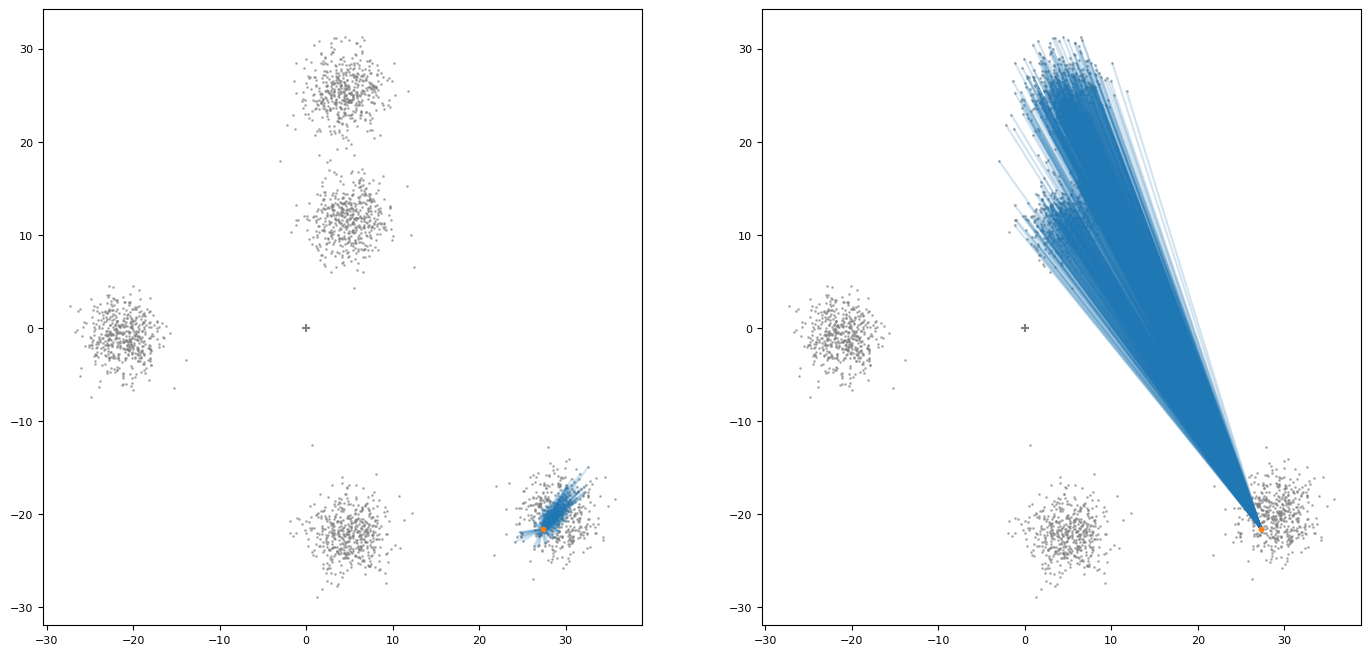

In [44]:
plot_mult_nns(X[511], nns_l, X)

In the similarity selection sim_mat>0.95 (left) we can see that there is the circular bias ($\perp$ to $\textbf{u}$). The dissimilarity is maximal for angles closer to $\pi$ and again points at a distance of $\lVert\textbf{u}\lVert$ from the origin.

We can modify the distance factor to correct the cicular bias: $$e^{\left(-\tau \big\lvert\lVert \textbf{u} \lVert - \lVert \textbf{v} \lVert\big\lvert\right)}$$

In [49]:
def sim_matrix_(X, quick=True, f=1):
    X_norm = normalize(X)
    dot_mat = X_norm @ X_norm.transpose(0,1)
    dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]
    norm_mat = dot_diag@dot_diag.transpose(0,1)
    if quick: mag_mat = torch.exp(-abs(dot_diag-dot_diag.transpose(0,1))*f)
    else: mag_mat = torch.exp(-torch.sqrt(((X_norm[:,None,:] - X_norm)**2).sum(2)))
    sim_mat = dot_mat/norm_mat*mag_mat 
    return sim_mat

In [46]:
sim_mat = sim_matrix_(X, f=0.1)
nns_l = nn_search(511, sim_mat, 0.99, -0.5)

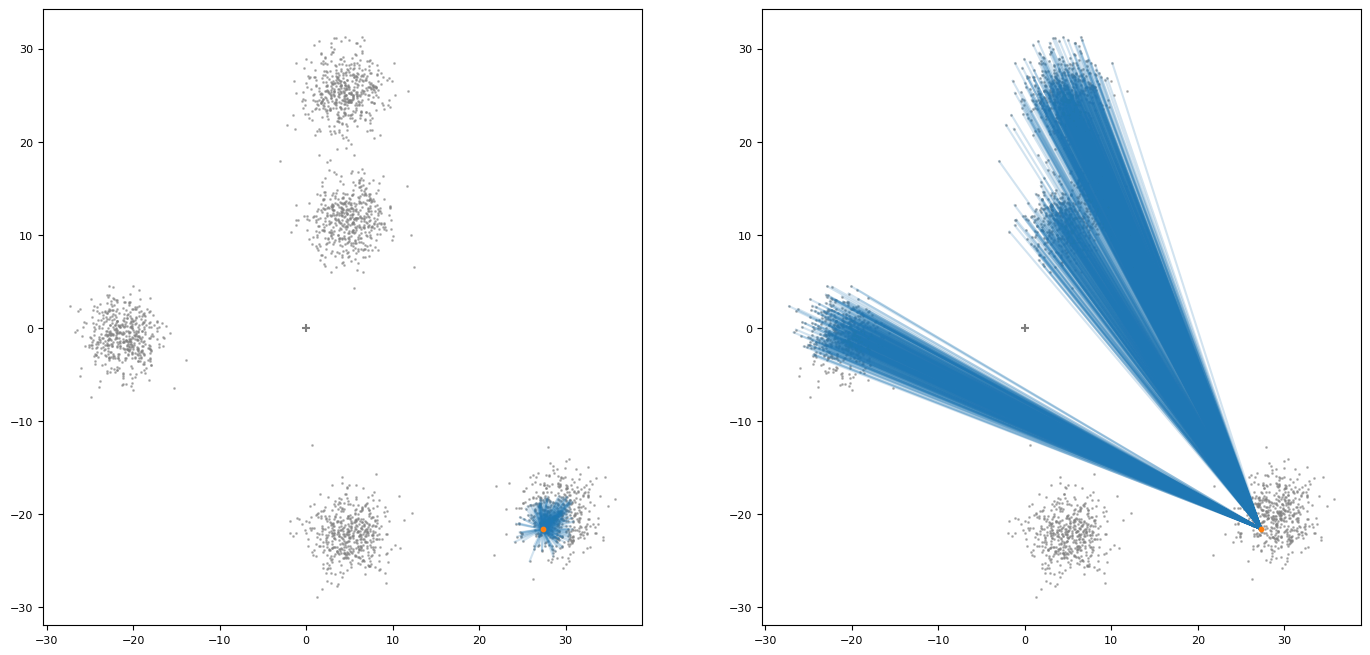

In [47]:
plot_mult_nns(X[511], nns_l, X)

And now when multiplying the similarity by $e^{\left(-\lVert \textbf{u} - \textbf{v} \lVert\right)}$ :

In [48]:
sim_mat = sim_matrix(X, quick=False)
dissim_bool = sim_mat<-0.2
sim_bool = sim_mat>0.9
nns_l = [sim_bool[511].nonzero().squeeze(), dissim_bool[714].nonzero().squeeze()]

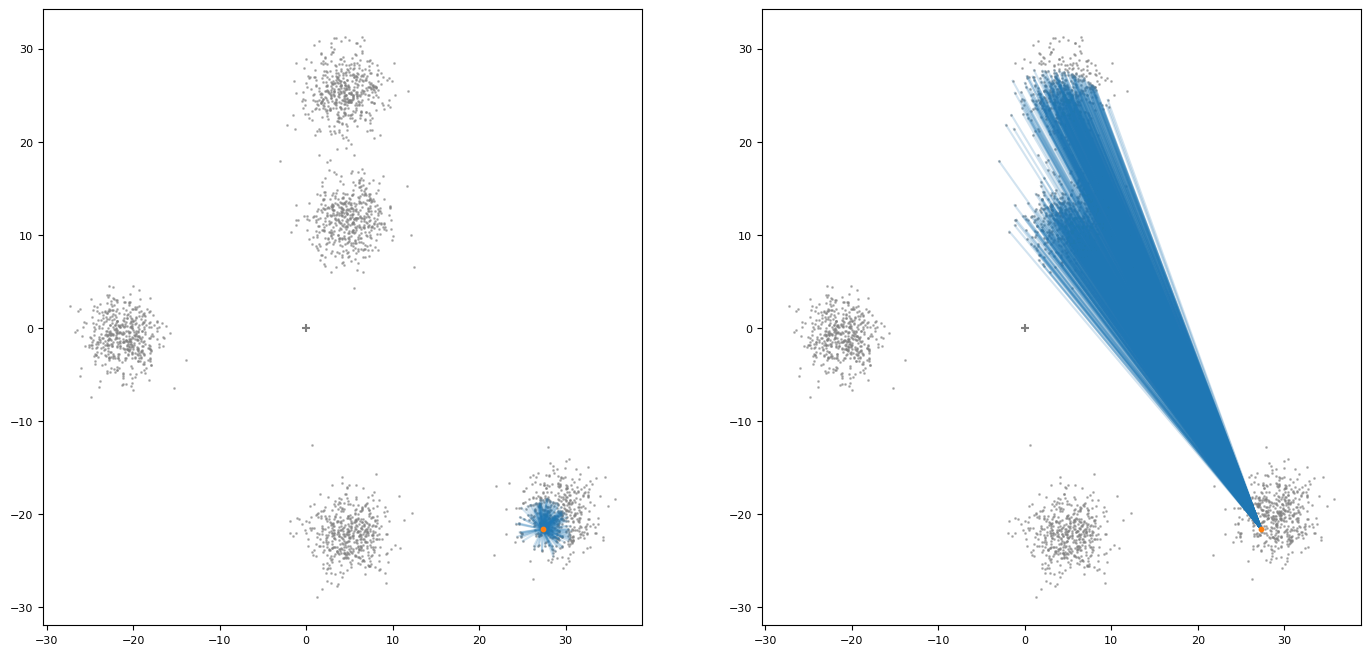

In [49]:
plot_mult_nns(X[511], nns_l, X)

The second factor is better because it respects the geometry of the points surrounding and gives a point centric result, it reintroduces the measure of distance. In the dissimialrity selection, one can see that the points that are the most dissimilar are always those opposite to the reference vector, at an angle of $\pi$ from the origin. This is a strong bias, with pure distance the local points are 

Looking at the dissimilarity plot above of point 71, we can see that the cluster at about $\left[x\sim0,y\sim-18\right]$ is caracterized as more dissimilar than the cluster at the top left corner. This is due to the projective nature of the calculation and thus the position of the origin versus the projection vectors: an angle that would produce a negative projection is more dissimilar than any positive projection.

The point 350 is close to the origin, so the most distant cluster is regarded as the lowest right.

We can vizualize the difference clearly in the following homogeneous example:

In [50]:
X_ = (torch.rand((10000,2))-0.5)*1500

In [51]:
X = X_

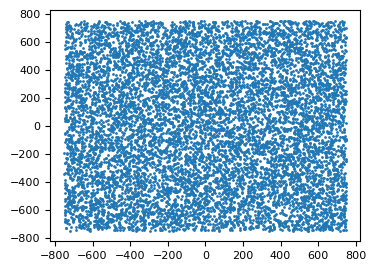

In [52]:
plt.scatter(*X.transpose(0,1), s=1)

In [53]:
# find a point in the lower right corner
iddx = torch.where(X[:,0]>500)[0]
idddx = torch.where(X[iddx][:,1]<-400)[0]
iddx[idddx]

tensor([  15,   22,   53,   65,   74,   87,   91,  149,  207,  219,  235,  239,  251,  257,  346,  377,  416,  421,  445,  457,  471,  474,
         491,  494,  495,  499,  521,  529,  537,  548,  559,  569,  590,  615,  616,  644,  667,  676,  686,  690,  718,  722,  723,  724,
         826,  850,  904,  913,  937,  944,  955,  965,  986, 1104, 1109, 1161, 1199, 1239, 1245, 1275, 1276, 1319, 1326, 1365, 1373, 1374,
        1376, 1379, 1412, 1436, 1469, 1486, 1522, 1544, 1598, 1599, 1617, 1629, 1637, 1666, 1677, 1686, 1715, 1732, 1736, 1776, 1794, 1798,
        1807, 1827, 1838, 1896, 1902, 2028, 2031, 2098, 2128, 2141, 2200, 2231, 2265, 2268, 2296, 2349, 2368, 2462, 2464, 2467, 2512, 2516,
        2578, 2588, 2637, 2654, 2658, 2675, 2703, 2705, 2736, 2743, 2757, 2760, 2774, 2780, 2828, 2831, 2902, 2932, 2976, 3004, 3008, 3011,
        3019, 3049, 3056, 3142, 3143, 3145, 3166, 3209, 3220, 3237, 3241, 3401, 3403, 3415, 3449, 3457, 3481, 3483, 3488, 3500, 3538, 3619,
        3655, 3704, 

In [54]:
# Cos Similarity
%%timeit -n 10
simm = cossim(X)
nns_l = nn_search(91,simm,0.99,-0.9)

265 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
simm = cossim(X)
nns_l = nn_search(91,simm,0.99,-0.9)

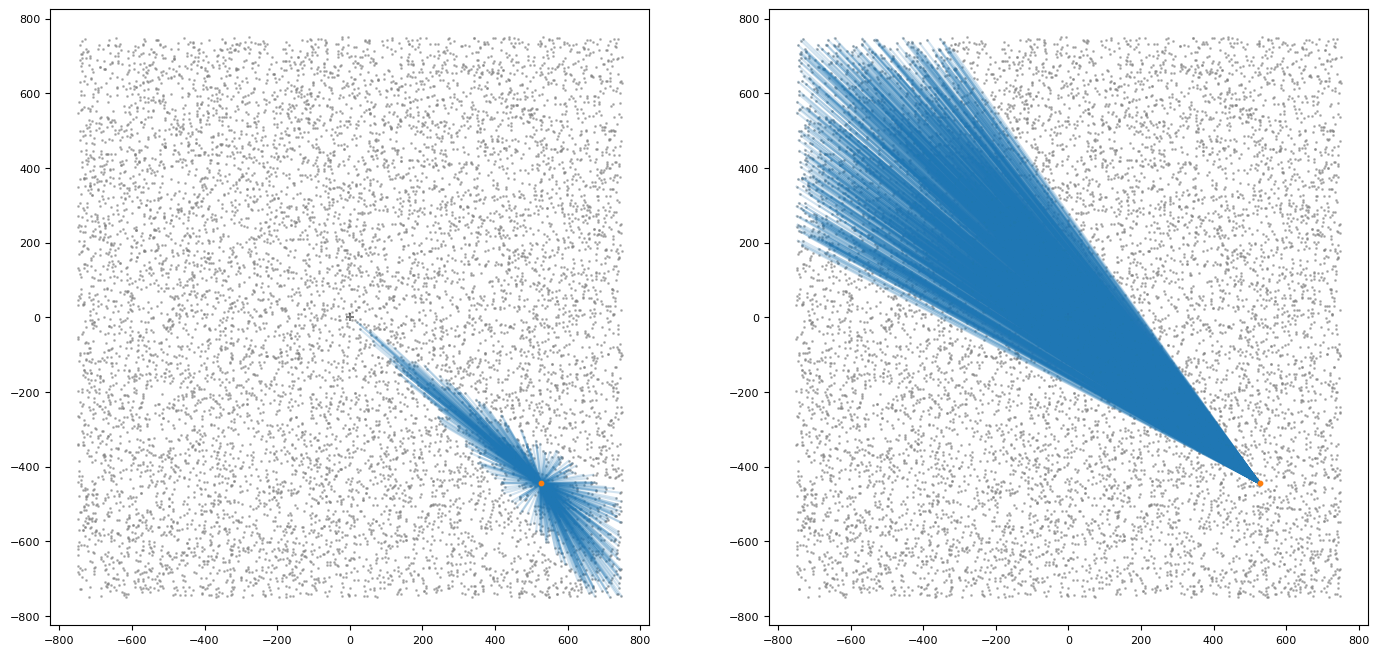

In [56]:
plot_mult_nns(X[91], nns_l, X)

In [63]:
# Cos Similarity weighted by the difference of the norms
%%timeit -n 10
simm = sim_matrix(X,quick=True)
nns_l = nn_search(91,simm,0.8,-0.9)

607 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
simm = sim_matrix(X,quick=True)
nns_l = nn_search(91,simm,0.8,-0.9)

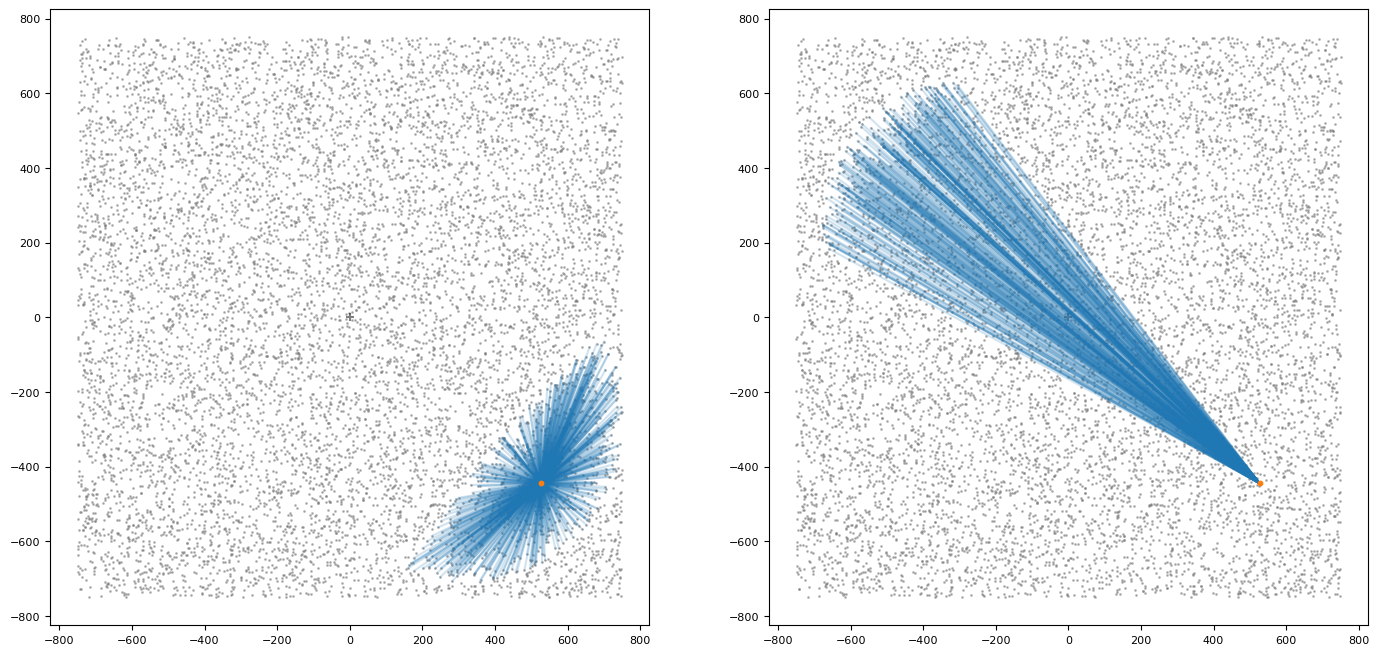

In [58]:
plot_mult_nns(X[91], nns_l, X)

In [64]:
# Cos Similarity weighted by the difference of the norms
%%timeit -n 10
sim_mat = sim_matrix_(X, quick=True, f=0.5)
nns_l = nn_search(91, sim_mat, 0.8, -0.9)

679 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
sim_mat = sim_matrix_(X, f=0.5)
nns_l = nn_search(91, sim_mat, 0.8, -0.9)

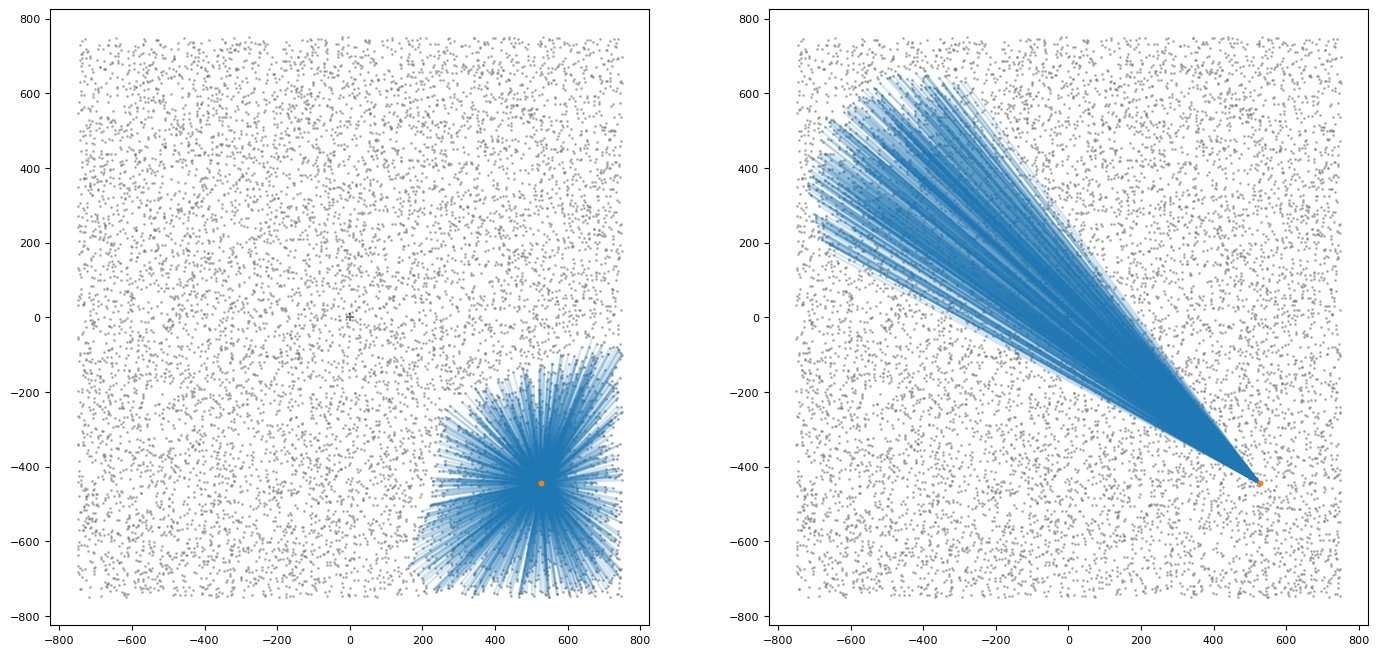

In [60]:
plot_mult_nns(X[91], nns_l, X)

In [65]:
# Cos Similarity weighted by the norm of the difference
%%timeit -n 10
simm = sim_matrix(X,quick=False)
nns_l = nn_search(91,simm,0.8,-0.3)

1.16 s ± 50.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
simm = sim_matrix(X,quick=False)
nns_l = nn_search(91,simm,0.8,-0.3)

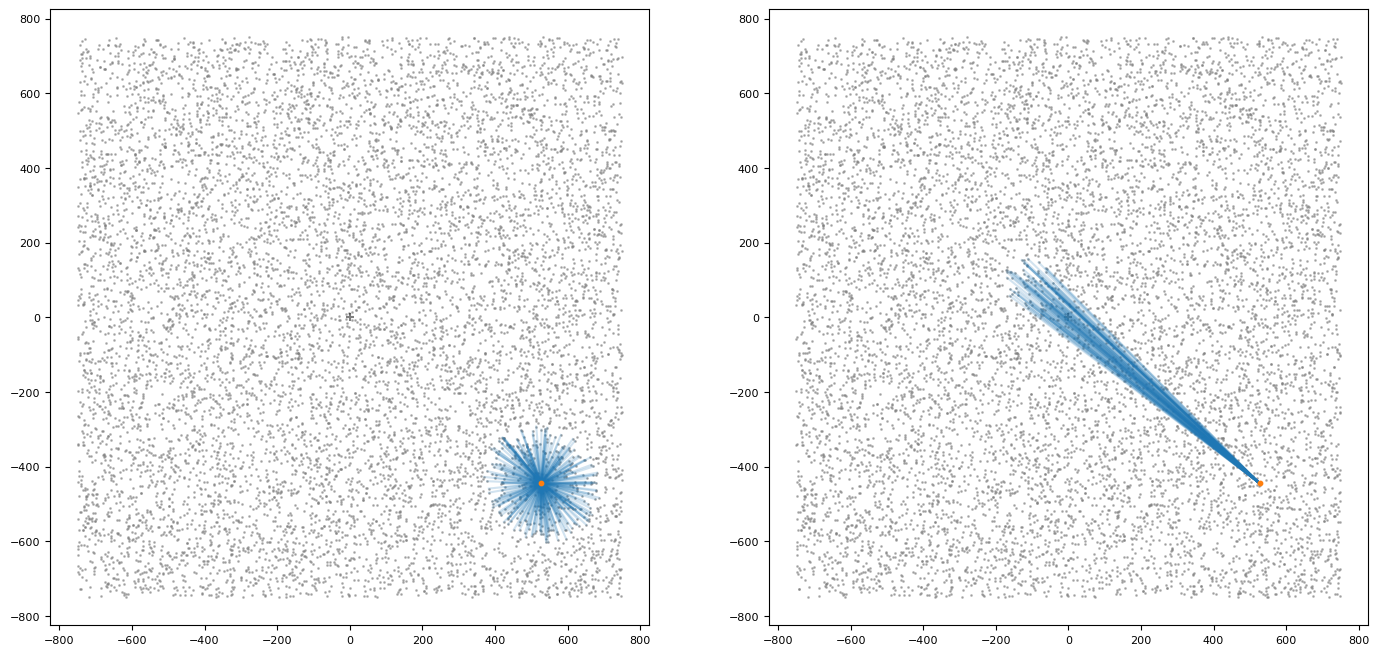

In [62]:
plot_mult_nns(X[91], nns_l, X)

> We performed all these calculation in the vectoria form where all the data was processed at the same time with the idea to use these methods to process a complete dataset. But if we only care about one point we can rewrite the functions as follows:

In [63]:
i = 91
x = X[i]

In [64]:
def normalize_(x,X):
    Xt = torch.cat((x[None,:],X))
    Xmin, Xmax = Xt.min(), Xt.max()
    Xt_norm = 2*(Xt-Xmin)/(Xmax-Xmin) - 1
    return Xt_norm[0], Xt_norm[1:]

In [65]:
def sim_vect(x, X, quick=True, f=None):
    xn, Xn = normalize_(x,X)
    dot_mat = xn @ Xn.transpose(0,1)
    xn_norm, Xn_norm = torch.sqrt((xn**2).sum()), torch.sqrt((Xn**2).sum(1))
    norm_mat = xn_norm * Xn_norm
    if quick: mag_mat = torch.exp(-abs(xn_norm - Xn_norm)*f)
    else: mag_mat = torch.exp(-torch.sqrt(((xn - Xn)**2).sum(1)))
    sim_vec = dot_mat/norm_mat*mag_mat 
    return sim_vec

In [66]:
def nn_search_(sim_mat, e_sim, e_dsim):
    sim_bool = sim_mat>e_sim
    dissim_bool = sim_mat<e_dsim
    return [sim_bool.nonzero().squeeze(), dissim_bool.nonzero().squeeze()]

In [67]:
sim_v = sim_vect(x,X,quick=True,f=0.1)
nn_l = nn_search_(sim_v,0.98,-0.8)

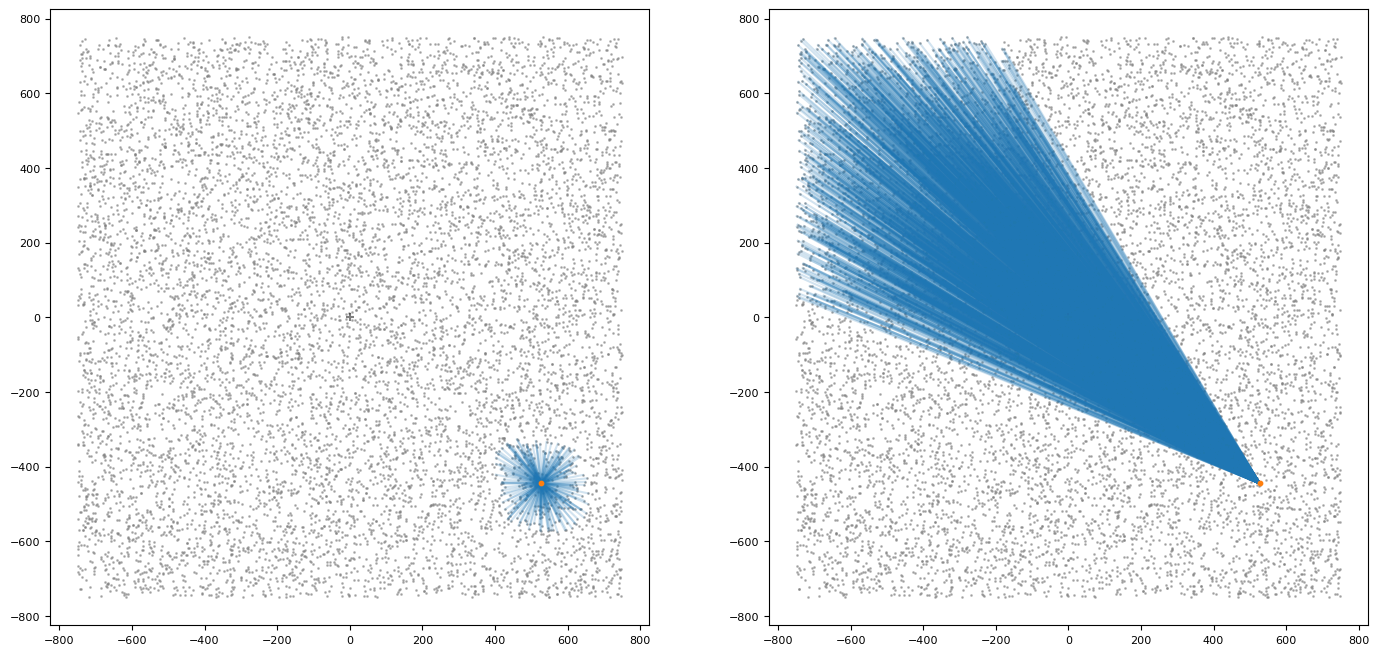

In [68]:
plot_mult_nns(x, nn_l, X)

In [69]:
%%timeit -n 10
sim_v = sim_vect(x,X,quick=True,f=0.1)
nn_l = nn_search_(sim_v,0.98,-0.8)

8.35 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### simple distance and cutoff:

In [70]:
def plot_nns(pt, nns, X, plot_angle=False, cos=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,8))
    for k in X[nns]:
        ax.plot(*torch.stack([pt, k]).transpose(0,1), alpha=0.2, color="C0")
    ax.scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
    ax.scatter(*pt.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)
    ax.scatter(0,0, marker='+', c='black', alpha=0.5)
    if plot_angle:
        theta = torch.acos(tensor(cos))
        xs = torch.linspace(-30,30,10)
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0]))*xs, linewidth=1, alpha=0.5, color='C3')
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0])+theta)*xs, linewidth=1, alpha=0.5, color='C4')
        ax.plot(xs, torch.tan(torch.arctan(pt[1]/pt[0])-theta)*xs, linewidth=1, alpha=0.5, color='C4')
#     ax.set_xlim(-30, 38)
#     ax.set_ylim(-32, 35);

In [71]:
eps = 150
i = 91

In [77]:
%%timeit -n 10
diff = X[:,None,:]-X
dists = torch.sqrt(torch.einsum('ijk,ijk->ij', diff, diff))
nn = torch.where(dists[i]<eps)

422 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [82]:
diff = X[:,None,:]-X
dists = torch.sqrt(torch.einsum('ijk,ijk->ij', diff, diff))
nns = torch.where(dists[i]<eps)

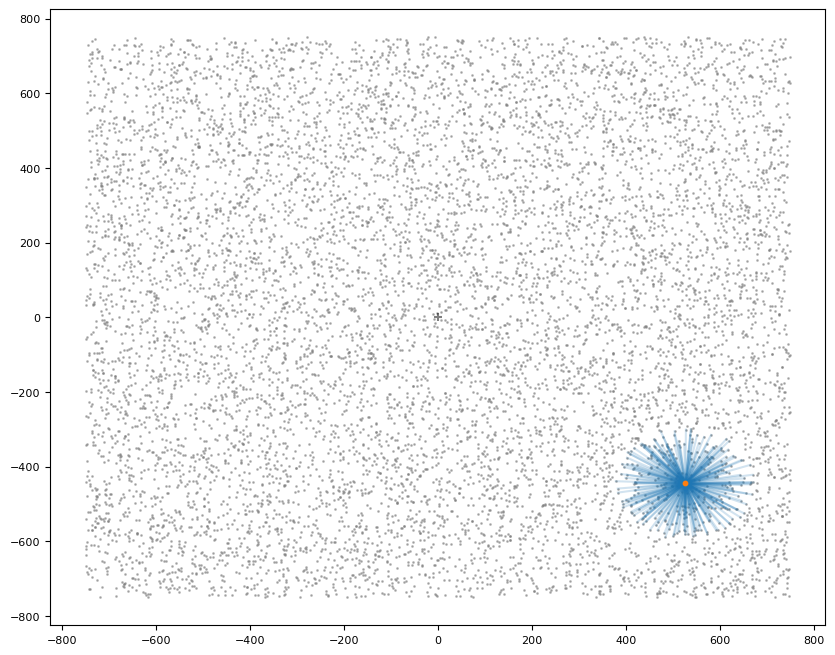

In [83]:
plot_nns(x, nns, X)

> For only one point:

In [84]:
%%timeit -n 10
dists = torch.sqrt(((x-X)**2).sum(1))
nns = torch.where(dists<eps)

285 µs ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [85]:
dists = torch.sqrt(((x-X)**2).sum(1))
nns = torch.where(dists<eps)

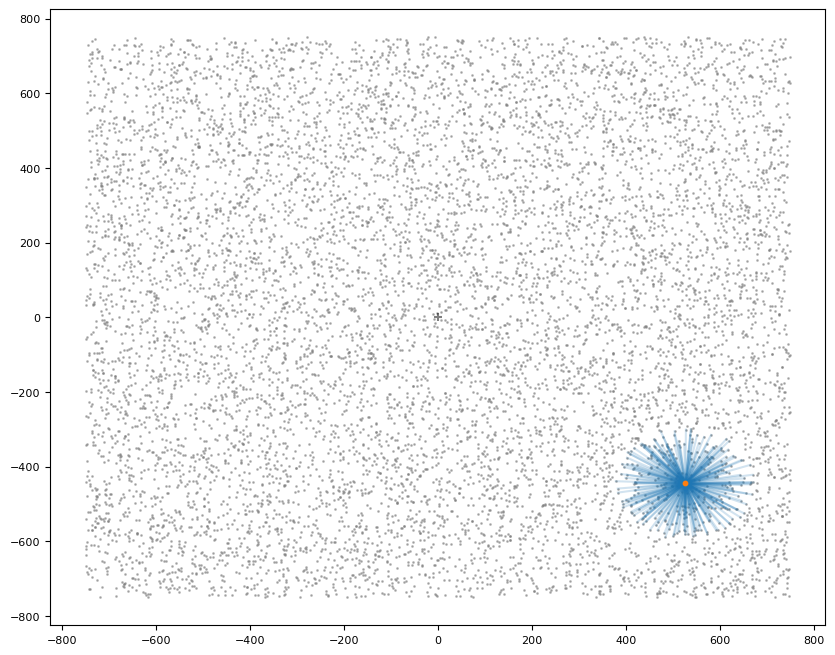

In [86]:
plot_nns(x,nns,X)